In [1]:
from pyspark.sql.types import StructType, StructField, StringType, LongType
jsonSchema = StructType([
    StructField('label', StringType(), True),
    StructField('tweet_id', LongType(), True),
    StructField('tweet_text', StringType(), True)
])

df=spark.read.format("json").schema(jsonSchema).load("/Users/Pavel/Documents/KULeuven/Courses/AdvancedAnalyticsinBigDataWorld/spark/data/*")

In [2]:
df.show()

+--------------+-------------------+--------------------+
|         label|           tweet_id|          tweet_text|
+--------------+-------------------+--------------------+
|        #china|1381303111222956033|https://t.co/Mz4B...|
|      #vaccine|1380298538802765827|Infectious diseas...|
|      #vaccine|1381494016211030016|Do u truly trust ...|
|        #covid|1380766615189479425|Do u use #███████...|
|        #biden|1380129673443696640|#███████ Wants #█...|
|#stopasianhate|1380973739224010757|QUEEN OF ASIA 📈?...|
|        #covid|1381746356730101760|What’s ur main fo...|
|        #biden|1380127152847347714|NO ONE WANTS TO B...|
|        #covid|1381347661396246531|Domain for sale: ...|
|        #china|1380180497062629376|Dm or comment (re...|
|        #biden|1380986061078282245|It was a lie, our...|
|        #biden|1380521381704708098|New platform Hypr...|
|        #china|1380182109097091072|Don't miss out th...|
|        #covid|1381753369576894465|The Amazing Singa...|
|        #china

## Text preprocessing

In [3]:
import pyspark.sql.functions as f
from pyspark.sql.functions import regexp_replace
from pyspark.sql.functions import ltrim

#Converting all letters to lowercase
df = df.withColumn("tweet_text",f.lower(f.col("tweet_text")))

#removing punctuations, numbers, http and spaces
df =df.withColumn("tweet_text",f.regexp_replace(f.col("tweet_text"),'([^ a-zA-Z\'])',''))
df = df.withColumn("tweet_text",f.regexp_replace(f.col("tweet_text"),'http.*?\\b',' '))
df = df.withColumn("tweet_text",f.ltrim(f.regexp_replace(f.col("tweet_text"),'[\r\n\t\f\v ]+', ' ')))



In [4]:
from pyspark.ml.feature import Tokenizer
from pyspark.ml.feature import StopWordsRemover

#Splitting words
tokenizer = Tokenizer(inputCol="tweet_text", outputCol="words")
dataset = tokenizer.transform(df)


In [5]:
#Lemmatization
import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer() 
#just to try if it works
print(lemmatizer.lemmatize("bats"))
print(lemmatizer.lemmatize("are"))
print(lemmatizer.lemmatize("feet"))
print(lemmatizer.lemmatize("stocks"))

[nltk_data] Downloading package wordnet to /Users/Pavel/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


bat
are
foot
stock


In [6]:
## Didn't manage to apply lemmatization while using WordNetLemmatizer on pyspark dataframe. 
#So temporarily to make it work, firstly changed to pandas dataframe and then back to pyspark dataframe.

In [7]:
pandas_df = dataset.select("*").toPandas()

In [8]:

pandas_df['lemmatized'] = pandas_df['words'].apply(
                    lambda lst:[lemmatizer.lemmatize(word) for word in lst])
pandas_df['lemmatized']

0        [could, be, a, messan, all, out, war, of, the,...
1        [infectious, disease, designated, bed, drastic...
2                         [do, u, truly, trust, safety, i]
3                                          [do, u, use, q]
4                   [want, but, get, amp, a, dominates, u]
                               ...                        
19405                                          [on, break]
19406                                      [so, bored, of]
19407                                           [get, the]
19408                                         [is, boring]
19409                                          [fuck, you]
Name: lemmatized, Length: 19410, dtype: object

In [9]:
dataset2 = spark.createDataFrame(pandas_df)

In [10]:
dataset2.show()

+--------------+-------------------+--------------------+--------------------+--------------------+
|         label|           tweet_id|          tweet_text|               words|          lemmatized|
+--------------+-------------------+--------------------+--------------------+--------------------+
|        #china|1381303111222956033|could be a messan...|[could, be, a, me...|[could, be, a, me...|
|      #vaccine|1380298538802765827|infectious diseas...|[infectious, dise...|[infectious, dise...|
|      #vaccine|1381494016211030016|do u truly trust ...|[do, u, truly, tr...|[do, u, truly, tr...|
|        #covid|1380766615189479425|         do u use q |     [do, u, use, q]|     [do, u, use, q]|
|        #biden|1380129673443696640|wants but gets am...|[wants, but, gets...|[want, but, get, ...|
|#stopasianhate|1380973739224010757|      queen of asia |   [queen, of, asia]|   [queen, of, asia]|
|        #covid|1381746356730101760|whats ur main for...|[whats, ur, main,...|[whats, ur, main,...|


In [11]:
#Removing stop words
stopwordList = ["u","ur", "amp", "q"] 
stopwordList.extend(StopWordsRemover().getStopWords())
remover = StopWordsRemover(inputCol="lemmatized", outputCol="filtered" ,stopWords=stopwordList)
dataset2 = remover.transform(dataset2)
dataset2.show()

+--------------+-------------------+--------------------+--------------------+--------------------+--------------------+
|         label|           tweet_id|          tweet_text|               words|          lemmatized|            filtered|
+--------------+-------------------+--------------------+--------------------+--------------------+--------------------+
|        #china|1381303111222956033|could be a messan...|[could, be, a, me...|[could, be, a, me...|[messan, war, world]|
|      #vaccine|1380298538802765827|infectious diseas...|[infectious, dise...|[infectious, dise...|[infectious, dise...|
|      #vaccine|1381494016211030016|do u truly trust ...|[do, u, truly, tr...|[do, u, truly, tr...|[truly, trust, sa...|
|        #covid|1380766615189479425|         do u use q |     [do, u, use, q]|     [do, u, use, q]|               [use]|
|        #biden|1380129673443696640|wants but gets am...|[wants, but, gets...|[want, but, get, ...|[want, get, domin...|
|#stopasianhate|1380973739224010

In [19]:
#to get rid of words like v, q, wa
#dataset2 = dataset2.withColumn("filtered2", f.expr("filter(filtered, x -> not(length(x) < 3))")).where(f.size(f.col("filtered2")) > 0).drop("filtered")
#dataset2.show()

In [12]:
dataset2.select("filtered").show(truncate = False)

+-----------------------------------------------------------------------------------------------------------------+
|filtered                                                                                                         |
+-----------------------------------------------------------------------------------------------------------------+
|[messan, war, world]                                                                                             |
|[infectious, disease, designated, bed, drastic, decreasejapan]                                                   |
|[truly, trust, safety]                                                                                           |
|[use]                                                                                                            |
|[want, get, dominates]                                                                                           |
|[queen, asia]                                                          

## Bag of words

In [13]:
#Vectorizing
from pyspark.ml.feature import CountVectorizer, StringIndexer
from pyspark.ml import Pipeline

cv = CountVectorizer(inputCol="filtered", outputCol="features")
label_stringIdx = StringIndexer(inputCol = "label", outputCol = "labelIndex")

pipeline = Pipeline(stages=[cv, label_stringIdx])

pipelineFit = pipeline.fit(dataset2)
dataset2= pipelineFit.transform(dataset2)
dataset2.show()

+--------------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|         label|           tweet_id|          tweet_text|               words|          lemmatized|            filtered|            features|labelIndex|
+--------------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|        #china|1381303111222956033|could be a messan...|[could, be, a, me...|[could, be, a, me...|[messan, war, world]|(35020,[22,143,28...|       2.0|
|      #vaccine|1380298538802765827|infectious diseas...|[infectious, dise...|[infectious, dise...|[infectious, dise...|(35020,[363,632,3...|       1.0|
|      #vaccine|1381494016211030016|do u truly trust ...|[do, u, truly, tr...|[do, u, truly, tr...|[truly, trust, sa...|(35020,[406,725,1...|       1.0|
|        #covid|1380766615189479425|         do u use q |     [do, u, use, q]|    

## Train and test split

In [14]:
(trainingData2, testData2) = dataset2.randomSplit([0.7, 0.3], seed = 100)
print("Training Dataset Count: " + str(trainingData2.count()))
print("Test Dataset Count: " + str(testData2.count()))

Training Dataset Count: 13524
Test Dataset Count: 5886


## Logistic Regression

In [15]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(labelCol = "labelIndex", featuresCol = "features", maxIter=20, regParam=0.3, elasticNetParam=0)
lrModel = lr.fit(trainingData2)
lrPredictions = lrModel.transform(testData2)

In [16]:
lrPredictions.select("prediction", "labelIndex").show()

+----------+----------+
|prediction|labelIndex|
+----------+----------+
|       4.0|       4.0|
|       4.0|       4.0|
|       4.0|       4.0|
|       4.0|       4.0|
|       4.0|       4.0|
|       4.0|       4.0|
|       0.0|       4.0|
|       4.0|       4.0|
|       1.0|       4.0|
|       4.0|       4.0|
|       4.0|       4.0|
|       0.0|       4.0|
|       2.0|       4.0|
|       3.0|       4.0|
|       0.0|       4.0|
|       0.0|       4.0|
|       0.0|       4.0|
|       0.0|       4.0|
|       0.0|       4.0|
|       1.0|       4.0|
+----------+----------+
only showing top 20 rows



In [17]:
import pyspark.sql.functions as col
lrPredictions.groupBy("prediction").count().orderBy(f.col("count").desc()).show()

+----------+-----+
|prediction|count|
+----------+-----+
|       0.0| 2243|
|       1.0| 1510|
|       2.0|  990|
|       3.0|  596|
|       4.0|  525|
|       5.0|   22|
+----------+-----+



### Evaluation

In [18]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
# Select (prediction, true label) and compute accuracy
evaluator = MulticlassClassificationEvaluator(
    labelCol="labelIndex", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(lrPredictions)
print(accuracy)
print("Test Error = %g " % (1.0 - accuracy))

0.6236833163438668
Test Error = 0.376317 


In [19]:
trainingSummary = lrModel.summary

print("False positive rate by label:")
for i, rate in enumerate(trainingSummary.falsePositiveRateByLabel):
    print("label %d: %s" % (i, rate))

print("True positive rate by label:")
for i, rate in enumerate(trainingSummary.truePositiveRateByLabel):
    print("label %d: %s" % (i, rate))

print("Precision by label:")
for i, prec in enumerate(trainingSummary.precisionByLabel):
    print("label %d: %s" % (i, prec))

print("Recall by label:")
for i, rec in enumerate(trainingSummary.recallByLabel):
    print("label %d: %s" % (i, rec))

print("F-measure by label:")
for i, f in enumerate(trainingSummary.fMeasureByLabel()):
    print("label %d: %s" % (i, f))

accuracy = trainingSummary.accuracy
falsePositiveRate = trainingSummary.weightedFalsePositiveRate
truePositiveRate = trainingSummary.weightedTruePositiveRate
fMeasure = trainingSummary.weightedFMeasure()
precision = trainingSummary.weightedPrecision
recall = trainingSummary.weightedRecall
print("Accuracy: %s\nFPR: %s\nTPR: %s\nF-measure: %s\nPrecision: %s\nRecall: %s"
      % (accuracy, falsePositiveRate, truePositiveRate, fMeasure, precision, recall))

False positive rate by label:
label 0: 0.03883594630597397
label 1: 0.02149912841371296
label 2: 0.0028403884918453363
label 3: 0.0006014779171678983
label 4: 0.0015329586101175269
label 5: 0.0
True positive rate by label:
label 0: 0.9699867197875166
label 1: 0.9627892432770482
label 2: 0.9578544061302682
label 3: 0.9453870625662778
label 4: 0.9124579124579124
label 5: 0.8021201413427562
Precision by label:
label 0: 0.9059786653435872
label 1: 0.932747652226598
label 2: 0.9877518767285658
label 3: 0.9960893854748604
label 4: 0.9890510948905109
label 5: 1.0
Recall by label:
label 0: 0.9699867197875166
label 1: 0.9627892432770482
label 2: 0.9578544061302682
label 3: 0.9453870625662778
label 4: 0.9124579124579124
label 5: 0.8021201413427562
F-measure by label:
label 0: 0.9368907131862494
label 1: 0.94753038929066
label 2: 0.9725734292939118
label 3: 0.970076169749728
label 4: 0.9492119089316987
label 5: 0.8901960784313726
Accuracy: 0.9514196983141082
FPR: 0.016729598052925943
TPR: 0.95141

In [25]:
from pyspark.mllib.classification import LogisticRegressionWithLBFGS
from pyspark.mllib.util import MLUtils
from pyspark.mllib.evaluation import MulticlassMetrics

In [62]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Create both evaluators
evaluatorMulti = MulticlassClassificationEvaluator(labelCol="labelIndex", predictionCol="prediction")

# Make predicitons
predictionAndTarget = lrPredictions.select("prediction", "labelIndex")

# Get metrics
acc = evaluatorMulti.evaluate(predictionAndTarget, {evaluatorMulti.metricName: "accuracy"})
f1 = evaluatorMulti.evaluate(predictionAndTarget, {evaluatorMulti.metricName: "f1"})
weightedPrecision = evaluatorMulti.evaluate(predictionAndTarget, {evaluatorMulti.metricName: "weightedPrecision"})
weightedRecall = evaluatorMulti.evaluate(predictionAndTarget, {evaluatorMulti.metricName: "weightedRecall"})
auc = evaluator.evaluate(predictionAndTarget)

In [63]:
evaluatorMulti.evaluate(predictionAndTarget) #gives F1 score


0.6251285894838685

In [64]:
print("ACC: %s" % acc)
print("F1 score: %s" % f1)
print("Weighted Precision: %s" % weightedPrecision)
print("Weighted Recall: %s" % weightedRecall)
print("AUC: %s" % auc)

ACC: 0.6236833163438668
F1 score: 0.6251285894838685
Weighted Precision: 0.6588853632667037
Weighted Recall: 0.6236833163438668
AUC: 0.6236833163438668


In [65]:
# Overall statistics
precision = metrics.precision()
recall = metrics.recall()
f1Score = metrics.fMeasure()
print("Summary Stats")
print("Precision = %s" % precision)
print("Recall = %s" % recall)
print("F1 Score = %s" % f1Score)

# Statistics by class
labels = data.map(lambda lp: lp.label).distinct().collect()
for label in sorted(labels):
    print("Class %s precision = %s" % (label, metrics.precision(label)))
    print("Class %s recall = %s" % (label, metrics.recall(label)))
    print("Class %s F1 Measure = %s" % (label, metrics.fMeasure(label, beta=1.0)))

# Weighted stats
print("Weighted recall = %s" % metrics.weightedRecall)
print("Weighted precision = %s" % metrics.weightedPrecision)
print("Weighted F(1) Score = %s" % metrics.weightedFMeasure())
print("Weighted F(0.5) Score = %s" % metrics.weightedFMeasure(beta=0.5))
print("Weighted false positive rate = %s" % metrics.weightedFalsePositiveRate)

AttributeError: module 'sklearn.metrics' has no attribute 'precision'

In [60]:
# this part does not work for now

trainingSummary = lrModel.summary

# Obtain the objective per iteration
# objectiveHistory = trainingSummary.objectiveHistory
# print("objectiveHistory:")
# for objective in objectiveHistory:
#     print(objective)

# Obtain the receiver-operating characteristic as a dataframe and areaUnderROC.
trainingSummary.roc.show(5)
print("areaUnderROC: " + str(trainingSummary.areaUnderROC))

# Set the model threshold to maximize F-Measure
fMeasure = trainingSummary.fMeasureByThreshold
maxFMeasure = fMeasure.groupBy().max('F-Measure').select('max(F-Measure)').head(5)
# bestThreshold = fMeasure.where(fMeasure['F-Measure'] == maxFMeasure['max(F-Measure)']) \
#     .select('threshold').head()['threshold']
# lr.setThreshold(bestThreshold)

AttributeError: 'LogisticRegressionTrainingSummary' object has no attribute 'roc'

In [61]:
print("Coefficients: \n" + str(lrModel.coefficientMatrix))

Coefficients: 
DenseMatrix([[ 4.79211769e-02,  1.57872402e-01,  4.66665461e-02, ...,
               0.00000000e+00,  2.52368007e-01,  6.46537556e-01],
             [ 2.12995752e-01,  1.20259845e-01, -2.48281289e-02, ...,
               0.00000000e+00, -6.65230614e-02, -3.63800257e-01],
             [-6.96676228e-02, -8.78544295e-02,  4.14897531e-02, ...,
               0.00000000e+00, -5.46761749e-02, -1.00894023e-01],
             [-8.85063169e-02, -8.73097362e-02, -4.51749307e-02, ...,
               0.00000000e+00, -4.97415097e-02, -8.36202774e-02],
             [-7.90924055e-02, -7.91638327e-02, -1.80136599e-02, ...,
               0.00000000e+00, -6.99523592e-02, -7.61314736e-02],
             [-2.36505842e-02, -2.38042486e-02, -1.39579617e-04, ...,
               0.00000000e+00, -1.14749022e-02, -2.20915253e-02]])


In [66]:
import matplotlib.pyplot as plt
import numpy as np
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [72]:
class_temp = lrPredictions.select("labelIndex").groupBy("labelIndex").count().sort('count', ascending=False).toPandas()
class_temp = class_temp["labelIndex"].values.tolist()
class_names = map(str, class_temp)
#print(class_name)
class_names

In [80]:
from sklearn.metrics import confusion_matrix
y_true = lrPredictions.select("labelIndex")
y_true = y_true.toPandas()

y_pred = lrPredictions.select("prediction")
y_pred = y_pred.toPandas()

cnf_matrix = confusion_matrix(y_true, y_pred)
cnf_matrix


array([[1162,  370,   82,   17,   38,    0],
       [ 433,  845,   34,    8,   19,    0],
       [ 253,  123,  716,   17,   42,    1],
       [ 159,   56,   35,  530,   19,    0],
       [ 198,  102,   89,   21,  398,    1],
       [  38,   14,   34,    3,    9,   20]])

Confusion matrix, without normalization
[[1162  370   82   17   38    0]
 [ 433  845   34    8   19    0]
 [ 253  123  716   17   42    1]
 [ 159   56   35  530   19    0]
 [ 198  102   89   21  398    1]
 [  38   14   34    3    9   20]]


TypeError: object of type 'map' has no len()

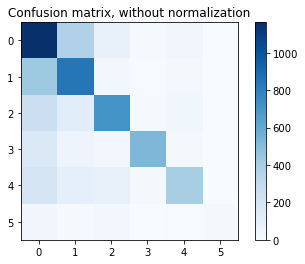

In [83]:
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,title='Confusion matrix, without normalization')
plt.show()

Normalized confusion matrix
[[0.69622528 0.22168963 0.04913122 0.01018574 0.02276812 0.        ]
 [0.32337565 0.63106796 0.02539208 0.00597461 0.01418969 0.        ]
 [0.21961806 0.10677083 0.62152778 0.01475694 0.03645833 0.00086806]
 [0.19899875 0.07008761 0.04380476 0.66332916 0.02377972 0.        ]
 [0.2447466  0.12608158 0.11001236 0.02595797 0.49196539 0.00123609]
 [0.3220339  0.11864407 0.28813559 0.02542373 0.07627119 0.16949153]]


TypeError: object of type 'map' has no len()

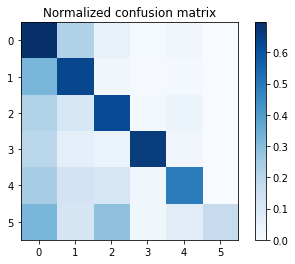

In [84]:
# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,title='Normalized confusion matrix')

plt.show()